# Random Ensemble Model

In [1]:
import sys
from os.path import abspath

sys.path.append(abspath('../src/'))

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from utils import *
from baseline_convnet import BaselineConvnet
import matplotlib.pyplot as plt
from sklearn import preprocessing
import random
from random_ensemble import RandomEnsemble

Using TensorFlow backend.


## Model description

Random Ensemble model classifies random projections of the training data in a lower dimensional space using the baseline model. 
Then classifies the original high dimensional data with a voting technique: it simply sums up the probabilities from of the classifiers for each class.
In the following examples, the model has been trained using a varying number of projections, subspace size equal to 8 (projected images of dimension 8x8).


## Recap of this notebook


Model accuracy (%): number of projections vs evaluation set


| n. projection | test set | FGSM attacks | deepfool attacks | projected gradient attacks |
| ------------- | -------- | ------------ | ---------------- | -------------------------- |
| 1 | 93.52 | 42.80 | 92.11 | 62.81 |
| 3 | 81.25 | 32.44 | 80.41 | 45.67 |
| 5 | 55.94 | 21.99 | 54.87 | 31.39 |
| 10 | 30.69 | 15.35 | 31.11 | 18.10 |

As the number of projections increases, accuracy decreases on both the test set and the adversaries.

# Single projection

Testing the model on a single projection.

In [3]:
x_train, y_train, x_test, y_test, input_shape, num_classes = preprocess_mnist()
model = RandomEnsemble(input_shape=input_shape, num_classes=num_classes, n_proj=1, size_proj=8)
classifier = model.load_classifier(
    relative_path="../trained_models/random_ensemble/random_ensemble_proj=1_size=8/",
    model_name = "random_ensemble")


Loading mnist.
x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)


### Test set evaluation
Evaluation of this model on the test set.

In [4]:
x_test_pred = model.evaluate_test(classifier, x_test, y_test)


Testing infos:
x_test.shape =  (10000, 28, 28, 1) 
y_test.shape =  (10000, 10) 


Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (1, 10000, 8, 8, 1)

Original test data.
Correctly classified: 9352
Incorrectly classified: 648
Test accuracy: 93.52%


### Adversaries evaluation
Evaluation on different adversarial perturbations of the test set, which have been projected along the training projection direction.

In [5]:
x_test_fgsm, x_test_fgsm_pred = model.evaluate_adversaries(classifier, x_test, y_test)


Adversarial evaluation using fgsm method.

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (1, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 4280
Incorrectly classified: 5720
Adversarial accuracy: 42.80%


In [6]:
x_test_deepfool, x_test_deepfool_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='deepfool',
                                        adversaries_path='../data/mnist_x_test_deepfool.pkl')


Adversarial evaluation using deepfool method.

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (1, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 9211
Incorrectly classified: 789
Adversarial accuracy: 92.11%


In [7]:
x_test_projected, x_test_projected_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='projected_gradient',
                                        adversaries_path='../data/mnist_x_test_projected_gradient.pkl')


Adversarial evaluation using projected_gradient method.

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (1, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 6281
Incorrectly classified: 3719
Adversarial accuracy: 62.81%


### Robust classifier

This is the same model trained using FGSM Adversarial training on a single projection.

In [9]:
robust_classifier = model.load_classifier(
                    relative_path="../trained_models/random_ensemble/robust_fgsm_seed=123/",
                    model_name="random_ensemble_robust_fgsm")

In [10]:
x_test_fgsm, x_test_fgsm_pred = model.evaluate_adversaries(robust_classifier, x_test, y_test, method='fgsm')


Adversarial evaluation using fgsm method.

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (1, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 7123
Incorrectly classified: 2877
Adversarial accuracy: 71.23%


### Robust classifier trasferability
Let's see how it performs against the other adversaries.

In [11]:
x_test_deepfool, x_test_deepfool_pred = model.evaluate_adversaries(robust_classifier, x_test, y_test, 
                                        method='deepfool',
                                        adversaries_path='../data/mnist_x_test_deepfool.pkl')


Adversarial evaluation using deepfool method.

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (1, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 9130
Incorrectly classified: 870
Adversarial accuracy: 91.30%


In [12]:
x_test_projected, x_test_projected_pred = model.evaluate_adversaries(robust_classifier, x_test, y_test, 
                                          method='projected_gradient',
                                          adversaries_path='../data/mnist_x_test_projected_gradient.pkl')


Adversarial evaluation using projected_gradient method.

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (1, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 7657
Incorrectly classified: 2343
Adversarial accuracy: 76.57%


### Single projection model vs baseline

The random ensemble model here is the one just trained (single projection model).

FGSM training is adversarial training on FGSM adversaries.

| model vs evaluation set | test set | FGSM attacks | deepfool attacks | projected gradient attacks | 
| ------------- | -------- | ------------ | ---------------- | -------------------- |
| baseline    | 99.23 | 24.17 | 56.80 | 12.58 | 
| random ens. | 93.52 | 42.80 | 92.11 | 62.81 |
| baseline + FGSM training | - | 81.45 | 97.46 | 25.92 |
| random ens. + FGSM training | - |  71.23 | 91.30 | 76.57


## Ensemble on 3 projections
This is the ensemble model trained on 3 different random projections of the original data.

In [27]:
x_train, y_train, x_test, y_test, input_shape, num_classes = preprocess_mnist()
model = RandomEnsemble(input_shape=input_shape, num_classes=num_classes, n_proj=3, size_proj=8)
classifier = model.load_classifier(
    relative_path="../trained_models/random_ensemble/random_ensemble_proj=3_size=8/",
    model_name = "random_ensemble")

# test set 
x_test_pred = model.evaluate_test(classifier, x_test, y_test)

# adversaries
x_test_fgsm, x_test_fgsm_pred = model.evaluate_adversaries(classifier, x_test, y_test)
x_test_deepfool, x_test_deepfool_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='deepfool',
                                        adversaries_path='../data/mnist_x_test_deepfool.pkl')
x_test_projected, x_test_projected_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='projected_gradient',
                                        adversaries_path='../data/mnist_x_test_projected_gradient.pkl')


Loading mnist.
x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)

Testing infos:
x_test.shape =  (10000, 28, 28, 1) 
y_test.shape =  (10000, 10) 


Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (3, 10000, 8, 8, 1)

Original test data.
Correctly classified: 8125
Incorrectly classified: 1875
Test accuracy: 81.25%

Adversarial evaluation using fgsm method.

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (3, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 3244
Incorrectly classified: 6756
Adversarial accuracy: 32.44%

Adversarial evaluation using deepfool method.

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (3, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 8041
Incorrectly classified: 1959
Adversarial accuracy: 80.41%

Adversarial evaluation using projected_gradient method.

Computing random projections.
Input shape:  (10000,

### What's happening in the ensemble classification?

Each model is trained in the lower dimensional space of the whole dataset projection along a subset of random directions.
After training these models separately, the final ensemble classification is simply argmax of the vector containing the sum of all probabilities in each class, as shown below for a particular image.

In [28]:
# getting the arrays containing 3 projected predictions and final ensemble prediction on the first image
x_test_projected = compute_projections(x_test, random_seeds=model.random_seeds,
                                               n_proj=model.n_proj, size_proj=model.size_proj)

predictions = np.array([classifier.predict(x_test_projected[i]) for i, classifier in enumerate(classifier)])

np.set_printoptions(suppress=True)
print("\nPredictions on the first element by each single classifier:\n", predictions[:, 0])
#print(predictions.shape)
# sum the probabilities across all predictors
summed_predictions = np.sum(predictions, axis=0)

print("\nEnsemble prediction on the first element:\n", summed_predictions[0])
#print(summed_predictions.shape)


Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (3, 10000, 8, 8, 1)

Predictions on the first element by each single classifier:
 [[0.04745529 0.00188083 0.01035858 0.21188359 0.00125252 0.44483757
  0.00074033 0.13916749 0.01394993 0.1284739 ]
 [0.00259137 0.00002327 0.48114488 0.42658636 0.00003032 0.01012747
  0.00002206 0.03735029 0.02623402 0.0158899 ]
 [0.00000004 0.00000041 0.00000277 0.00001737 0.00000067 0.00000228
  0.         0.9995009  0.00000014 0.0004754 ]]

Ensemble prediction on the first element:
 [0.05004669 0.00190451 0.49150622 0.6384873  0.0012835  0.45496735
 0.0007624  1.1760187  0.04018409 0.14483918]


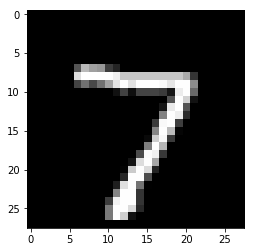

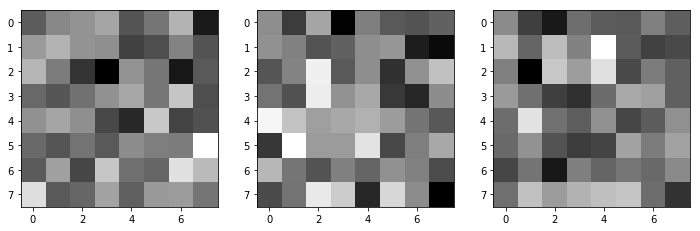

In [23]:
# original image
im = x_test[0].reshape(28,28)
plt.imshow(im, cmap='gray')
plt.show()

# projected images
im_test = [im.reshape(8, 8) for im in x_test_projected[:,0]]

f, ax = plt.subplots(1, 3, figsize=(6,6))
for i in range(3):
    ax[i].imshow(im_test[i], cmap='gray')
plt.show()

## 5 projections

In [25]:
x_train, y_train, x_test, y_test, input_shape, num_classes = preprocess_mnist()
model = RandomEnsemble(input_shape=input_shape, num_classes=num_classes, n_proj=5, size_proj=8)
classifier = model.load_classifier(
    relative_path="../trained_models/random_ensemble/random_ensemble_proj=5_size=8/",
    model_name = "random_ensemble")

# test set 
x_test_pred = model.evaluate_test(classifier, x_test, y_test)

# adversaries
x_test_fgsm, x_test_fgsm_pred = model.evaluate_adversaries(classifier, x_test, y_test)
x_test_deepfool, x_test_deepfool_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='deepfool',
                                        adversaries_path='../data/mnist_x_test_deepfool.pkl')
x_test_projected, x_test_projected_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='projected_gradient',
                                        adversaries_path='../data/mnist_x_test_projected_gradient.pkl')


Loading mnist.
x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)

Testing infos:
x_test.shape =  (10000, 28, 28, 1) 
y_test.shape =  (10000, 10) 


Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (5, 10000, 8, 8, 1)

Original test data.
Correctly classified: 5594
Incorrectly classified: 4406
Test accuracy: 55.94%

Adversarial evaluation using fgsm method.

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (5, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 2199
Incorrectly classified: 7801
Adversarial accuracy: 21.99%

Adversarial evaluation using deepfool method.

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (5, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 5487
Incorrectly classified: 4513
Adversarial accuracy: 54.87%

Adversarial evaluation using projected_gradient method.

Computing random projections.
Input shape:  (10000,

## 10 projections

In [24]:
x_train, y_train, x_test, y_test, input_shape, num_classes = preprocess_mnist()
model = RandomEnsemble(input_shape=input_shape, num_classes=num_classes, n_proj=10, size_proj=8)
classifier = model.load_classifier(
    relative_path="../trained_models/random_ensemble/random_ensemble_proj=10_size=8/",
    model_name = "random_ensemble")

# test set 
x_test_pred = model.evaluate_test(classifier, x_test, y_test)

# adversaries
x_test_fgsm, x_test_fgsm_pred = model.evaluate_adversaries(classifier, x_test, y_test)
x_test_deepfool, x_test_deepfool_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='deepfool',
                                        adversaries_path='../data/mnist_x_test_deepfool.pkl')
x_test_projected, x_test_projected_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='projected_gradient',
                                        adversaries_path='../data/mnist_x_test_projected_gradient.pkl')


Loading mnist.
x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)

Testing infos:
x_test.shape =  (10000, 28, 28, 1) 
y_test.shape =  (10000, 10) 


Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (10, 10000, 8, 8, 1)

Original test data.
Correctly classified: 3069
Incorrectly classified: 6931
Test accuracy: 30.69%

Adversarial evaluation using fgsm method.

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (10, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 1535
Incorrectly classified: 8465
Adversarial accuracy: 15.35%

Adversarial evaluation using deepfool method.

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (10, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 3111
Incorrectly classified: 6889
Adversarial accuracy: 31.11%

Adversarial evaluation using projected_gradient method.

Computing random projections.
Input shape:  (100